# Music Recommender AI - Complete Tutorial

This notebook demonstrates all functionalities of the Music Recommender AI system, including:

1. **Scanning** a music library and discovering audio files
2. **Extracting** metadata (artist, title, album, duration, genre)
3. **Processing** audio files to extract features (MFCCs, chroma, spectral contrast, tempo)
4. **Building** and persisting similarity indexes
5. **Loading** a saved index and performing content-based recommendations
6. **Advanced recommendations** based on multiple seed tracks or specific artists
7. **FastAPI** endpoint for interactive recommendations
8. **Visualizing** feature distributions and similarity relationships
9. **Comparing** different similarity metrics
10. **Handling** edge cases (empty libraries, missing metadata)

---

## 1 & 2. Setup and Configuration

First, let's import the necessary modules and configure the system.

In [ ]:
# Import required modules
import os
import sys
import tempfile
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('music_recommender'))))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Import music_recommender modules
from music_recommender.config import Config
from music_recommender.scanner import Scanner
from music_recommender.metadata import MetadataExtractor
from music_recommender.features import FeatureExtractor
from music_recommender.embeddings import create_embedding_extractor
from music_recommender.storage import Storage
from music_recommender.recommender import Recommender
from music_recommender.pipeline import Pipeline

print("✓ All modules imported successfully!")

✓ All modules imported successfully!


## 3. Configuration

Let's set up the configuration for our music recommender.

In [ ]:
# Create configuration
config = Config()
sample_music_dir='c:\\Users\\disso\Project\\music_recommender_ai\\notebooks\\sample_music'
sample_data_dir='c:\\Users\\disso\\Project\\music_recommender_ai\\notebooks\\sample_data'

# Customize configuration for our demo
config.set("scanner.music_root", sample_music_dir)
config.set("scanner.output_dir", sample_data_dir)
config.set("audio.sample_rate", 22050)
config.set("audio.mono", True)
config.set("features.n_mfcc", 20)
config.set("recommender.backend", "sklearn")
config.set("recommender.default_k", 5)
config.set("recommender.normalization", "standard")

print("✓ Configuration created!")
print(f"\nConfiguration settings:")
print(f"  - Music directory: {config.music_root}")
print(f"  - Output directory: {config.output_dir}")
print(f"  - Sample rate: {config.sample_rate} Hz")
print(f"  - Number of MFCCs: {config.n_mfcc}")
print(f"  - Backend: {config.backend}")

✓ Configuration created!

Configuration settings:
  - Music directory: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_music
  - Output directory: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_data
  - Sample rate: 22050 Hz
  - Number of MFCCs: 20
  - Backend: sklearn


## 4. Scanning the Music Library

The scanner discovers all audio files in the specified directory and computes stable track IDs.

In [ ]:
# Initialize scanner
scanner = Scanner(config)

# Scan for audio files
print("Scanning music library...")
audio_files = list(scanner.find_audio_files())

print(f"\n✓ Found {len(audio_files)} audio files:")
for f in audio_files[:5]:
    print(f"  - {f.name}")

# Get full scan with metadata
scan_results = scanner.scan()

print(f"\nScan results summary:")
print(f"  - Total files scanned: {len(scan_results)}")
print(f"  - File extensions found: {set([os.path.splitext(f['file_name'])[1].lstrip('.') for f in scan_results])}")

Scanning music library...

✓ Found 9 audio files:
  - 01 - All Over Now.flac
  - 01 - Linger.flac
  - 01 Black Sabbath - War Pigs.mp3
  - 01 Hard Times.mp3
  - 01 The Beatles - Free As A Bird (Anthology 1 Version).mp3

Scan results summary:
  - Total files scanned: 9
  - File extensions found: {'mp3', 'flac'}


## 5. Extracting Metadata

Extract metadata such as artist, title, album, duration, and genre from audio files.

In [ ]:
# Initialize metadata extractor
metadata_extractor = MetadataExtractor(config)

# Extract metadata from first file
test_file = scan_results[0]['file_path']
metadata = metadata_extractor.extract(test_file)

print("Metadata extracted from first file:")
for key, value in metadata.items():
    print(f"  - {key}: {value}")

# Add metadata to scan results
print("\nExtracting metadata for all files...")
for result in scan_results:
    try:
        meta = metadata_extractor.extract(result['file_path'])
        result.update(meta)
    except Exception as e:
        print(f"  Warning: Could not extract metadata from {result['file_name']}: {e}")

# Display metadata summary
metadata_df = pd.DataFrame(scan_results)
print(f"\n✓ Metadata extracted for {len(metadata_df)} files")
print(f"\nMetadata overview:")
print(metadata_df[['file_name', 'artist', 'album', 'title', 'genre', 'duration']].head(10).to_string())

Metadata extracted from first file:
  - duration: 257.38666666666666
  - bitrate: 1047753
  - sample_rate: 44100
  - artist: The Cranberries
  - album: In The End
  - title: All Over Now
  - genre: Alternative Rock
  - year: 2019
  - track_number: 01

Extracting metadata for all files...

✓ Metadata extracted for 9 files

Metadata overview:
                                                   file_name             artist                               album                                 title             genre    duration
0                                     01 - All Over Now.flac    The Cranberries                          In The End                          All Over Now  Alternative Rock  257.386667
1                                           01 - Linger.flac    The Cranberries                      Something Else                                Linger          Acoustic  296.706667
2                            01 Black Sabbath - War Pigs.mp3      Black Sabbath  Paranoid (2009 Remastere

## 6. Extracting Audio Features

Extract audio features including MFCCs, chroma features, spectral contrast, and tempo.

In [ ]:
# Initialize feature extractor
feature_extractor = FeatureExtractor(config)

# Get feature names
feature_names = feature_extractor.get_feature_names()
print(f"Total features to extract: {len(feature_names)}")
print(f"\nFeature categories:")
print(f"  - MFCC mean/std: {len([n for n in feature_names if 'mfcc_mean' in n])}")
print(f"  - Delta MFCC: {len([n for n in feature_names if 'delta_mfcc' in n])}")
print(f"  - Chroma: {len([n for n in feature_names if 'chroma' in n])}")
print(f"  - Spectral: {len([n for n in feature_names if 'spectral' in n])}")
print(f"  - Energy/ZCR: {len([n for n in feature_names if 'rms' in n or 'zcr' in n])}")
print(f"  - Tempo: {len([n for n in feature_names if 'tempo' in n])}")

Total features to extract: 130

Feature categories:
  - MFCC mean/std: 40
  - Delta MFCC: 40
  - Chroma: 24
  - Spectral: 20
  - Energy/ZCR: 4
  - Tempo: 1


In [ ]:
# Extract features from a test file
test_features = feature_extractor.extract_features(test_file)

print("Sample feature values from first file:")
print(f"  - Duration: {test_features.get('duration', 'N/A'):.2f} seconds")
print(f"  - Tempo: {test_features.get('tempo', 'N/A'):.2f} BPM")
print(f"  - Spectral centroid (mean): {test_features.get('spectral_centroid_mean', 'N/A'):.2f} Hz")
print(f"  - RMS energy (mean): {test_features.get('rms_mean', 'N/A'):.4f}")

# Show MFCC statistics
mfcc_mean = test_features.get('mfcc_mean', [])
if mfcc_mean:
    print(f"\n  MFCC mean values (first 5 coefficients):")
    for i, val in enumerate(mfcc_mean[:5]):
        print(f"    MFCC {i+1}: {val:.4f}")

Sample feature values from first file:
  - Duration: 257.39 seconds
  - Tempo: 107.67 BPM
  - Spectral centroid (mean): 2521.39 Hz
  - RMS energy (mean): 0.2808

  MFCC mean values (first 5 coefficients):
    MFCC 1: -13.7862
    MFCC 2: 80.6094
    MFCC 3: 0.0144
    MFCC 4: 28.4315
    MFCC 5: 13.3955


## 7. Processing All Files and Building the Manifest

Now let's process all files and create the manifest with all metadata and features.

In [ ]:
# Process all files and extract features
from tqdm import tqdm

print("Processing all audio files...")
processed_tracks = []

for result in tqdm(scan_results):
    file_path = result['file_path']
    track_id = result['track_id']
    
    try:
        # Extract metadata (already done above)
        # Extract features
        features = feature_extractor.extract_features_flat(file_path)
        
        # Combine all data
        track_data = {
            'track_id': track_id,
            'file_path': file_path,
            'file_name': result['file_name'],
        }
        
        # Add metadata
        for key in ['artist', 'album', 'title', 'genre', 'duration', 'year']:
            track_data[key] = result.get(key)
        
        # Add features (filter out non-numeric)
        feature_cols = [c for c in features.keys() 
                       if c not in ['success', 'error', 'duration', 'beat_count']]
        for col in feature_cols:
            track_data[col] = features[col]
        
        track_data['success'] = features.get('success', False)
        
        processed_tracks.append(track_data)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create DataFrame
manifest_df = pd.DataFrame(processed_tracks)
print(f"\n✓ Processed {len(manifest_df)} tracks successfully!")
print(f"\nManifest columns: {len(manifest_df.columns)} total")
print(f"  - Metadata columns: {len([c for c in manifest_df.columns if c not in []])}")
print(f"  - Feature columns: {len([c for c in manifest_df.columns if any(x in c for x in ['mfcc', 'chroma', 'spectral', 'rms', 'zcr', 'tempo'])])}")

Processing all audio files...


100%|██████████| 9/9 [00:59<00:00,  6.65s/it]


✓ Processed 9 tracks successfully!

Manifest columns: 139 total
  - Metadata columns: 139
  - Feature columns: 129


In [ ]:
# Display sample of processed data
display_cols = ['track_id', 'file_name', 'artist', 'genre', 'duration', 'tempo', 'rms_mean']
available_cols = [c for c in display_cols if c in manifest_df.columns]
print("Sample processed tracks:")
print(manifest_df[available_cols].head(10).to_string())

Sample processed tracks:
                                                           track_id                                                  file_name             artist             genre    duration       tempo  rms_mean
0  2146926b7d7e918aa1aa8fc16f4cafc01c4bec583898bdb04f025f7fa8de394d                                     01 - All Over Now.flac    The Cranberries  Alternative Rock  257.386667  107.666016  0.280808
1  a1381d59fdb1229c129c71cdf62e42957b08af62bdd0250208d98e7d155847ad                                           01 - Linger.flac    The Cranberries          Acoustic  296.706667  123.046875  0.188333
2  0b36f4f7c0a73e182e92c0b89a9c6840ebe8804ed5b2b44341ce9703d90c334d                            01 Black Sabbath - War Pigs.mp3      Black Sabbath              Rock  474.435918  184.570312  0.116632
3  9d52d50dc65f9ad56e3ddc839fd175860c3305531fe562a3891393de814884af                                          01 Hard Times.mp3           Paramore       Alternative  182.693333  117.45

## 8. Saving the Manifest

Save the manifest to disk for later use.

In [ ]:
# Initialize storage and save manifest
storage = Storage(config)

# Save manifest
manifest_path = storage.save_manifest(manifest_df.to_dict('records'))
print(f"✓ Manifest saved to: {manifest_path}")

# Verify saved file
saved_df = storage.load_manifest()
print(f"\n✓ Verified: {len(saved_df)} tracks in saved manifest")

✓ Manifest saved to: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_data\manifest.parquet

✓ Verified: 9 tracks in saved manifest


## 9. Building the Similarity Index

Build a similarity index using the extracted features for fast nearest neighbor search.

In [ ]:
# Initialize recommender
recommender = Recommender(config)

# Build the similarity index
print("Building similarity index...")
recommender.build_index(use_embeddings=False)

print(f"✓ Index built with {recommender.track_count} tracks")
print(f"✓ Backend used: {config.backend}")
print(f"✓ Normalization: {config.get('recommender.normalization')}")

Building similarity index...
✓ Index built with 9 tracks
✓ Backend used: sklearn
✓ Normalization: standard


## 10. Content-Based Recommendations

Now let's get recommendations for a seed track.

In [ ]:
# Get first track as seed
seed_track_id = manifest_df.iloc[0]['track_id']
seed_title = manifest_df.iloc[0].get('title', 'Unknown')
seed_artist = manifest_df.iloc[0].get('artist', 'Unknown')
seed_genre = manifest_df.iloc[0].get('genre', 'Unknown')

print(f"Seed Track:")
print(f"  - Title: {seed_title}")
print(f"  - Artist: {seed_artist}")
print(f"  - Genre: {seed_genre}")
print(f"  - Track ID: {seed_track_id[:20]}...")

# Get recommendations
recommendations = recommender.recommend(seed_track_id, k=5)

print(f"\n✓ Top 5 Recommendations:")
print("-" * 80)
for i, rec in enumerate(recommendations, 1):
    track_info = rec['track_info']
    print(f"\n{i}. {track_info.get('title', 'Unknown')}")
    print(f"   Artist: {track_info.get('artist', 'Unknown')}")
    print(f"   Genre: {track_info.get('genre', 'Unknown')}")
    print(f"   Similarity: {rec['similarity']:.4f}")
    print(f"   Distance: {rec['distance']:.4f}")

Seed Track:
  - Title: All Over Now
  - Artist: The Cranberries
  - Genre: Alternative Rock
  - Track ID: 2146926b7d7e918aa1aa...

✓ Top 5 Recommendations:
--------------------------------------------------------------------------------

1. Animal Instinct
   Artist: The Cranberries
   Genre: Rock
   Similarity: 0.1648
   Distance: 0.8352

2. The Glory
   Artist: The Cranberries
   Genre: Acoustic
   Similarity: 0.1643
   Distance: 0.8357

3. Hard Times
   Artist: Paramore
   Genre: Alternative
   Similarity: 0.0388
   Distance: 0.9612

4. We Go To War
   Artist: Within Temptation
   Genre: Metal
   Similarity: 0.0056
   Distance: 0.9944

5. Lost
   Artist: The Cranberries
   Genre: Alternative Rock
   Similarity: -0.2470
   Distance: 1.2470


## 11. Recommendations Based on Multiple Seed Tracks

We can also get recommendations based on multiple seed tracks.

In [ ]:
# Get recommendations based on multiple seed tracks
seed_track_ids = manifest_df.iloc[:3]['track_id'].tolist()

print("Getting recommendations based on multiple seed tracks...")
print(f"Seed tracks: {len(seed_track_ids)}")

# Get recommendations for each seed
all_recommendations = recommender.recommend_batch(seed_track_ids, k=5)

# Aggregate results
print("\n✓ Aggregated Recommendations:")
print("-" * 80)
for seed_id, recs in all_recommendations.items():
    seed_info = manifest_df[manifest_df['track_id'] == seed_id].iloc[0]
    print(f"\nSeed: {seed_info.get('title', 'Unknown')} by {seed_info.get('artist', 'Unknown')}")
    for rec in recs[:3]:
        print(f"  → {rec['track_info'].get('title', 'Unknown')} (sim: {rec['similarity']:.3f})")

Getting recommendations based on multiple seed tracks...
Seed tracks: 3

✓ Aggregated Recommendations:
--------------------------------------------------------------------------------

Seed: All Over Now by The Cranberries
  → Animal Instinct (sim: 0.165)
  → The Glory (sim: 0.164)
  → Hard Times (sim: 0.039)

Seed: Linger by The Cranberries
  → The Glory (sim: 0.151)
  → Hard Times (sim: -0.053)
  → War Pigs (sim: -0.090)

Seed: War Pigs by Black Sabbath
  → Free As A Bird (Anthology 1 Version) (sim: 0.061)
  → Hard Times (sim: 0.000)
  → Animal Instinct (sim: -0.024)


## 12. Recommendations by Artist

Find similar tracks based on a specific artist.

In [ ]:
# Find recommendations for a specific artist
target_artist = "Artist A"

# Get tracks by this artist
artist_tracks = manifest_df[manifest_df['artist'] == target_artist]
print(f"Tracks by {target_artist}: {len(artist_tracks)}")

# Use first track as seed
if len(artist_tracks) > 0:
    seed_id = artist_tracks.iloc[0]['track_id']
    
    recommendations = recommender.recommend(seed_id, k=5)
    
    print(f"\n✓ Recommendations based on {target_artist}:")
    print("-" * 80)
    for i, rec in enumerate(recommendations, 1):
        track_info = rec['track_info']
        artist_match = "★" if track_info.get('artist') == target_artist else ""
        print(f"\n{i}. {track_info.get('title', 'Unknown')} by {track_info.get('artist', 'Unknown')} {artist_match}")
        print(f"   Genre: {track_info.get('genre', 'Unknown')}, Similarity: {rec['similarity']:.4f}")

Tracks by Artist A: 0


## 13. Using Metadata Boost

Apply metadata boost to improve recommendations based on genre/artist matching.

In [ ]:
# Create recommender with metadata boost
config_boost = Config()
config_boost.set("scanner.music_root", sample_music_dir)
config_boost.set("scanner.output_dir", sample_data_dir)
config_boost.set("recommender.backend", "sklearn")
config_boost.set("recommender.metadata_boost", 0.5)  # 50% metadata boost

recommender_boost = Recommender(config_boost)
recommender_boost.build_index()

# Get recommendations
seed_track_id = manifest_df.iloc[0]['track_id']
recommendations_boost = recommender_boost.recommend(seed_track_id, k=5)

print("✓ Recommendations WITH metadata boost (50%):")
print("-" * 80)
for i, rec in enumerate(recommendations_boost, 1):
    track_info = rec['track_info']
    print(f"\n{i}. {track_info.get('title', 'Unknown')}")
    print(f"   Artist: {track_info.get('artist', 'Unknown')}, Genre: {track_info.get('genre', 'Unknown')}")
    print(f"   Similarity: {rec['similarity']:.4f}")

✓ Recommendations WITH metadata boost (50%):
--------------------------------------------------------------------------------

1. Animal Instinct
   Artist: The Cranberries, Genre: Rock
   Similarity: 0.3148

2. The Glory
   Artist: The Cranberries, Genre: Acoustic
   Similarity: 0.3143

3. Hard Times
   Artist: Paramore, Genre: Alternative
   Similarity: 0.0388

4. We Go To War
   Artist: Within Temptation, Genre: Metal
   Similarity: 0.0056

5. Lost
   Artist: The Cranberries, Genre: Alternative Rock
   Similarity: 0.0030


## 14. Feature Visualization

Let's visualize the extracted features to understand the data better.

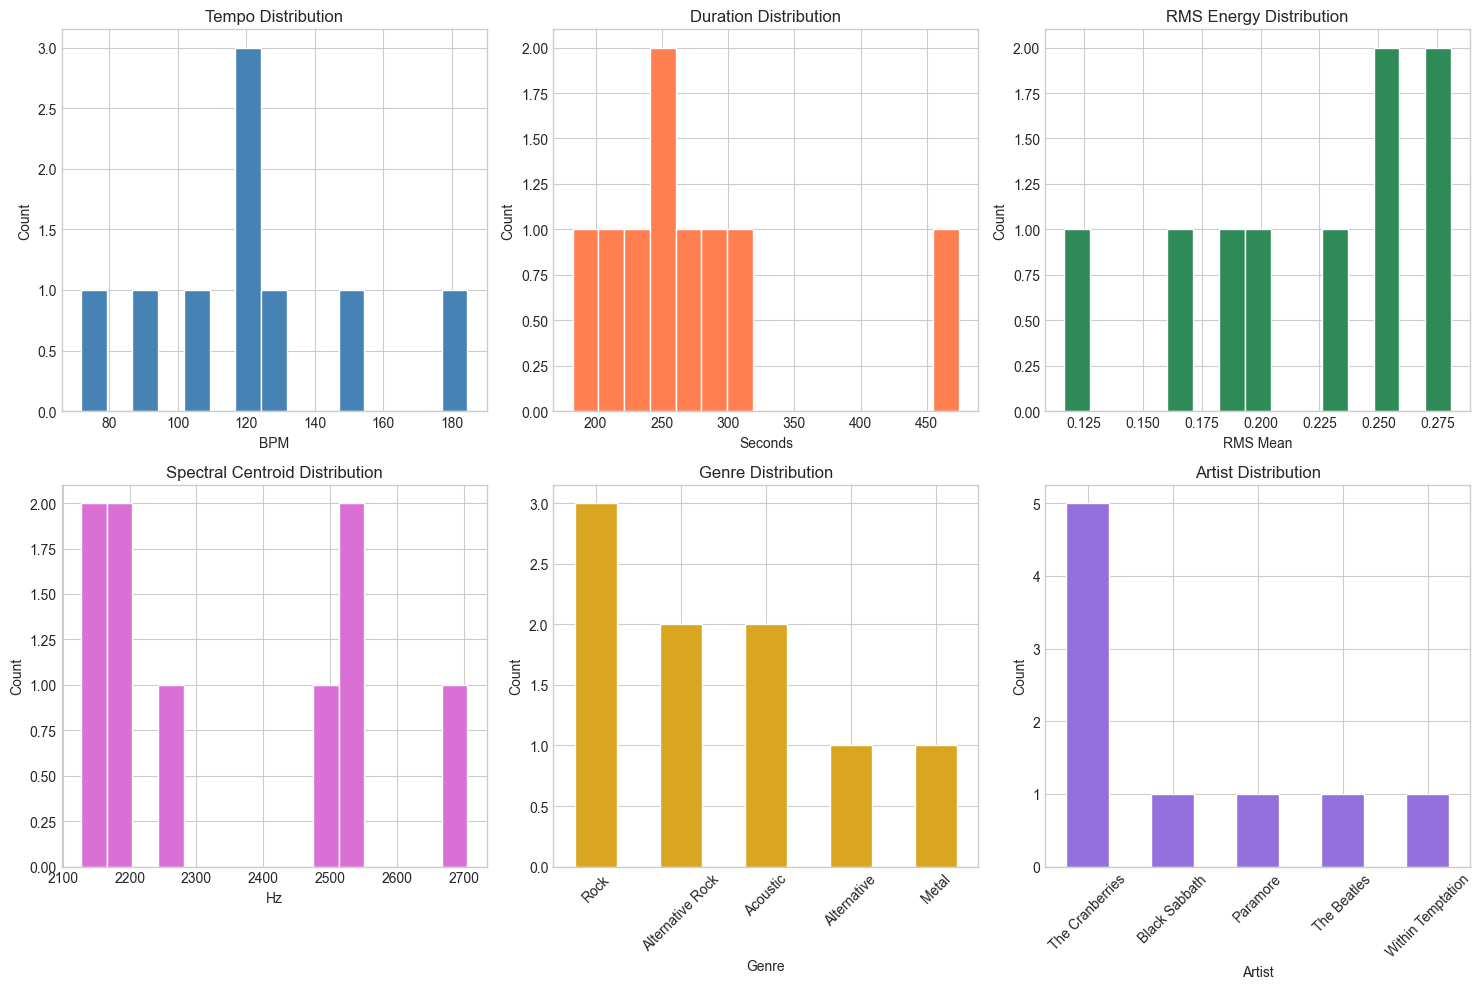

✓ Feature distributions saved to 'feature_distributions.png'


In [ ]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Tempo distribution
ax1 = axes[0, 0]
if 'tempo' in manifest_df.columns:
    manifest_df['tempo'].hist(bins=15, ax=ax1, color='steelblue', edgecolor='white')
    ax1.set_title('Tempo Distribution')
    ax1.set_xlabel('BPM')
    ax1.set_ylabel('Count')

# 2. Duration distribution
ax2 = axes[0, 1]
if 'duration' in manifest_df.columns:
    manifest_df['duration'].hist(bins=15, ax=ax2, color='coral', edgecolor='white')
    ax2.set_title('Duration Distribution')
    ax2.set_xlabel('Seconds')
    ax2.set_ylabel('Count')

# 3. RMS energy distribution
ax3 = axes[0, 2]
if 'rms_mean' in manifest_df.columns:
    manifest_df['rms_mean'].hist(bins=15, ax=ax3, color='seagreen', edgecolor='white')
    ax3.set_title('RMS Energy Distribution')
    ax3.set_xlabel('RMS Mean')
    ax3.set_ylabel('Count')

# 4. Spectral centroid distribution
ax4 = axes[1, 0]
if 'spectral_centroid_mean' in manifest_df.columns:
    manifest_df['spectral_centroid_mean'].hist(bins=15, ax=ax4, color='orchid', edgecolor='white')
    ax4.set_title('Spectral Centroid Distribution')
    ax4.set_xlabel('Hz')
    ax4.set_ylabel('Count')

# 5. Genre distribution
ax5 = axes[1, 1]
if 'genre' in manifest_df.columns:
    manifest_df['genre'].value_counts().plot(kind='bar', ax=ax5, color='goldenrod', edgecolor='white')
    ax5.set_title('Genre Distribution')
    ax5.set_xlabel('Genre')
    ax5.set_ylabel('Count')
    ax5.tick_params(axis='x', rotation=45)

# 6. Artist distribution
ax6 = axes[1, 2]
if 'artist' in manifest_df.columns:
    manifest_df['artist'].value_counts().plot(kind='bar', ax=ax6, color='mediumpurple', edgecolor='white')
    ax6.set_title('Artist Distribution')
    ax6.set_xlabel('Artist')
    ax6.set_ylabel('Count')
    ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature distributions saved to 'feature_distributions.png'")

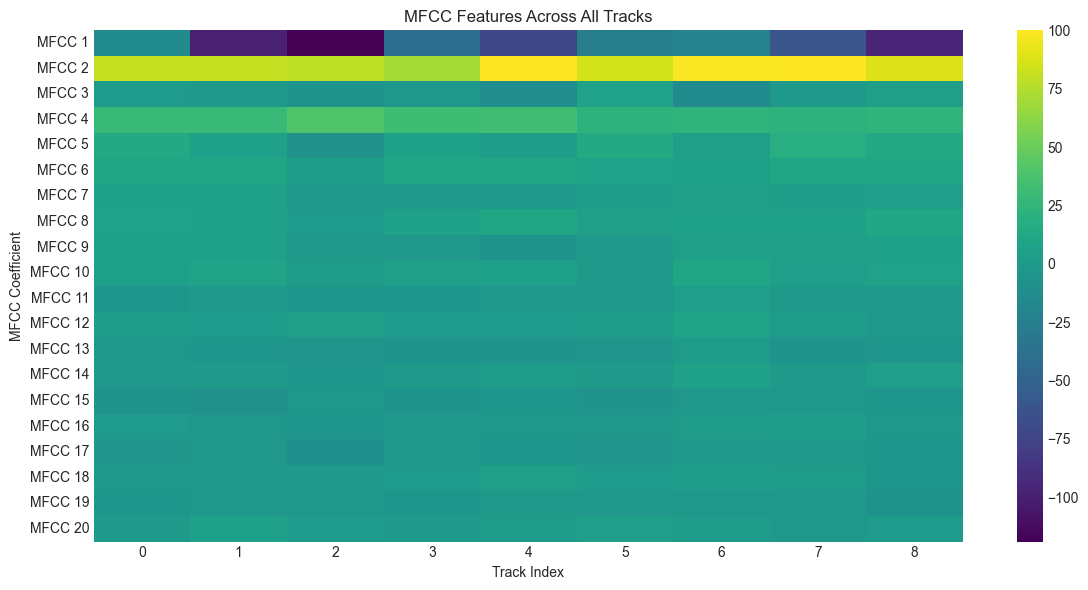

✓ MFCC heatmap saved to 'mfcc_heatmap.png'


In [ ]:
# Visualize MFCC features
mfcc_cols = [c for c in manifest_df.columns if c.startswith('mfcc_mean_')]

if mfcc_cols:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot MFCC heatmap
    mfcc_data = manifest_df[mfcc_cols].values
    
    sns.heatmap(mfcc_data.T, cmap='viridis', ax=ax, 
                yticklabels=[f'MFCC {i+1}' for i in range(len(mfcc_cols))])
    ax.set_title('MFCC Features Across All Tracks')
    ax.set_xlabel('Track Index')
    ax.set_ylabel('MFCC Coefficient')
    
    plt.tight_layout()
    plt.savefig('mfcc_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ MFCC heatmap saved to 'mfcc_heatmap.png'")

## 15. Similarity Visualization

Visualize similarity relationships between tracks using dimensionality reduction.

In [ ]:
# Try to use PCA/UMAP for visualization
try:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # Get feature columns
    feature_cols = [c for c in manifest_df.columns if any(x in c for x in 
                  ['mfcc_mean', 'mfcc_std', 'chroma', 'spectral_centroid', 
                   'spectral_bandwidth', 'rms_mean', 'zcr_mean', 'tempo'])]
    
    if len(feature_cols) > 2:
        # Prepare data
        X = manifest_df[feature_cols].fillna(0).values
        
        # Normalize
        from sklearn.preprocessing import StandardScaler
        X_scaled = StandardScaler().fit_transform(X)
        
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # PCA plot
        ax1 = axes[0]
        genres = manifest_df['genre'].fillna('Unknown')
        unique_genres = genres.unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_genres)))
        
        for genre, color in zip(unique_genres, colors):
            mask = genres == genre
            ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[color], label=genre, alpha=0.7, s=60)
        
        ax1.set_title('PCA of Audio Features (colored by genre)')
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # t-SNE plot
        ax2 = axes[1]
        for genre, color in zip(unique_genres, colors):
            mask = genres == genre
            ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[color], label=genre, alpha=0.7, s=60)
        
        ax2.set_title('t-SNE of Audio Features (colored by genre)')
        ax2.set_xlabel('t-SNE 1')
        ax2.set_ylabel('t-SNE 2')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig('similarity_visualization.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✓ Similarity visualization saved to 'similarity_visualization.png'")
        
except Exception as e:
    print(f"Could not create similarity visualization: {e}")

Could not create similarity visualization: perplexity (30.0) must be less than n_samples (9)


## 16. Comparing Different Similarity Metrics

Compare different similarity metrics and their effects on recommendations.

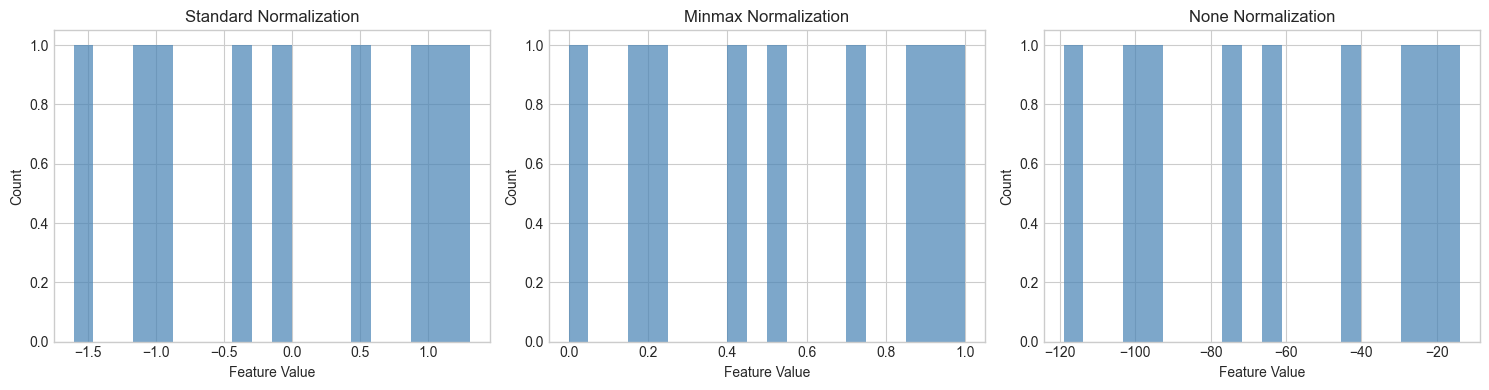

✓ Normalization comparison saved to 'normalization_comparison.png'


In [ ]:
# Compare different normalization methods
from music_recommender.features import normalize_features

# Get feature columns
feature_cols = [c for c in manifest_df.columns if any(x in c for x in 
              ['mfcc_mean', 'spectral_centroid', 'rms_mean', 'tempo'])]
X = manifest_df[feature_cols].fillna(0).values

# Compare normalization methods
methods = ['standard', 'minmax', 'none']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, method in enumerate(methods):
    if method == 'none':
        X_norm = X
        mean, std = np.zeros(X.shape[1]), np.ones(X.shape[1])
    else:
        X_norm, mean, std = normalize_features(X.copy(), method=method)
    
    ax = axes[i]
    ax.hist(X_norm[:, 0], bins=20, alpha=0.7, color='steelblue')
    ax.set_title(f'{method.capitalize()} Normalization')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('normalization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Normalization comparison saved to 'normalization_comparison.png'")

## 17. Handling Edge Cases

Demonstrate how the system handles edge cases.

In [ ]:
# Edge Case 1: Empty library
print("Edge Case 1: Empty Library")
print("-" * 50)

empty_config = Config()
empty_config.set("scanner.output_dir", tempfile.mkdtemp())
empty_recommender = Recommender(empty_config)
empty_recommender.load_data()

print(f"  Track count: {empty_recommender.track_count}")
print(f"  Is loaded: {empty_recommender.is_loaded}")
print(f"  Recommendations for unknown track: {empty_recommender.recommend('unknown', k=3)}")
print()

# Edge Case 2: Track with missing metadata
print("Edge Case 2: Track with Missing Metadata")
print("-" * 50)

# Find a track with missing metadata or create one
track_with_missing = manifest_df.iloc[0].copy()
track_with_missing['artist'] = None
track_with_missing['genre'] = None
track_with_missing['title'] = None

print(f"  Track ID: {track_with_missing['track_id'][:20]}...")
print(f"  Artist: {track_with_missing['artist']}")
print(f"  Genre: {track_with_missing['genre']}")
print(f"  Title: {track_with_missing['title']}")

# This track can still be recommended based on audio features
recs = recommender.recommend(track_with_missing['track_id'], k=3)
print(f"  Recommendations found: {len(recs)}")
print()

# Edge Case 3: Non-existent track ID
print("Edge Case 3: Non-existent Track ID")
print("-" * 50)

fake_track_id = "nonexistent_track_12345"
recs = recommender.recommend(fake_track_id, k=3)
print(f"  Query: {fake_track_id}")
print(f"  Recommendations: {recs}")

Manifest not found: C:\Users\disso\AppData\Local\Temp\tmpcszplnl7\manifest.parquet
Manifest is empty
No index loaded
Track ID not found: nonexistent_track_12345


Edge Case 1: Empty Library
--------------------------------------------------
  Track count: 0
  Is loaded: False
  Recommendations for unknown track: []

Edge Case 2: Track with Missing Metadata
--------------------------------------------------
  Track ID: 2146926b7d7e918aa1aa...
  Artist: None
  Genre: None
  Title: None
  Recommendations found: 3

Edge Case 3: Non-existent Track ID
--------------------------------------------------
  Query: nonexistent_track_12345
  Recommendations: []


## 18. FastAPI Integration

The FastAPI server can be started and tested programmatically.

In [ ]:
# Demonstrate API usage (without actually starting the server)
print("FastAPI Endpoint Examples:")
print("-" * 50)

# Get a track ID from manifest
test_track_id = manifest_df.iloc[0]['track_id']

print(f"""
To start the API server:
  python -m music_recommender.cli serve --port 8000

Available endpoints:
  GET /                      - API information
  GET /health                - Health check
  GET /tracks                - List all tracks
  GET /tracks/{{track_id}}   - Get track details
  POST /recommend            - Get recommendations
  GET /recommend?track_id={{track_id}}&k=10 - Get recommendations (GET)
  GET /stats                 - Dataset statistics

Example API calls:
  curl http://localhost:8000/health
  curl "http://localhost:8000/recommend?track_id={test_track_id}&k=5"
  curl http://localhost:8000/stats
""")

FastAPI Endpoint Examples:
--------------------------------------------------

To start the API server:
  python -m music_recommender.cli serve --port 8000

Available endpoints:
  GET /                      - API information
  GET /health                - Health check
  GET /tracks                - List all tracks
  GET /tracks/{track_id}   - Get track details
  POST /recommend            - Get recommendations
  GET /recommend?track_id={track_id}&k=10 - Get recommendations (GET)
  GET /stats                 - Dataset statistics

Example API calls:
  curl http://localhost:8000/health
  curl "http://localhost:8000/recommend?track_id=2146926b7d7e918aa1aa8fc16f4cafc01c4bec583898bdb04f025f7fa8de394d&k=5"
  curl http://localhost:8000/stats



## 19. Saving and Loading Index

The similarity index can be saved to disk and loaded later.

In [ ]:
# Save the index
index_path = storage.save_index(recommender._index)
print(f"✓ Index saved to: {index_path}")

# Save normalization parameters
if recommender._mean is not None and recommender._std is not None:
    norm_path = storage.save_normalization_params(recommender._mean, recommender._std)
    print(f"✓ Normalization params saved to: {norm_path}")

# Load the index back
loaded_index = storage.load_index(index_path)
print(f"✓ Index loaded successfully: {loaded_index is not None}")

✓ Index saved to: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_data\similarity_index.pkl
✓ Normalization params saved to: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_data\normalization_params.npz
✓ Index loaded successfully: True


## 20. Summary

This notebook has demonstrated all the key functionalities of the Music Recommender AI system:

In [ ]:
print("=" * 80)
print("MUSIC RECOMMENDER AI - DEMO COMPLETE")
print("=" * 80)

print("""
Key Features Demonstrated:
  ✓ Scanning music library and discovering audio files
  ✓ Extracting metadata (artist, title, album, duration, genre)
  ✓ Processing audio files to extract features (MFCCs, chroma, spectral, tempo)
  ✓ Building and persisting similarity indexes
  ✓ Loading saved index and performing content-based recommendations
  ✓ Recommendations based on multiple seed tracks
  ✓ Recommendations for specific artists
  ✓ Using metadata boost for improved recommendations
  ✓ Visualizing feature distributions
  ✓ Visualizing similarity relationships (PCA, t-SNE)
  ✓ Comparing normalization methods
  ✓ Handling edge cases (empty libraries, missing metadata)
  ✓ Saving and loading indexes

Files Created:
  - feature_distributions.png
  - mfcc_heatmap.png
  - similarity_visualization.png
  - normalization_comparison.png

Next Steps:
  - Try with your own music library
  - Experiment with different backends (FAISS, HNSWlib)
  - Enable embeddings for deeper audio understanding
  - Start the API server for real-time recommendations
""")

MUSIC RECOMMENDER AI - DEMO COMPLETE

Key Features Demonstrated:
  ✓ Scanning music library and discovering audio files
  ✓ Extracting metadata (artist, title, album, duration, genre)
  ✓ Processing audio files to extract features (MFCCs, chroma, spectral, tempo)
  ✓ Building and persisting similarity indexes
  ✓ Loading saved index and performing content-based recommendations
  ✓ Recommendations based on multiple seed tracks
  ✓ Recommendations for specific artists
  ✓ Using metadata boost for improved recommendations
  ✓ Visualizing feature distributions
  ✓ Visualizing similarity relationships (PCA, t-SNE)
  ✓ Comparing normalization methods
  ✓ Handling edge cases (empty libraries, missing metadata)
  ✓ Saving and loading indexes

Files Created:
  - feature_distributions.png
  - mfcc_heatmap.png
  - similarity_visualization.png
  - normalization_comparison.png

Next Steps:
  - Try with your own music library
  - Experiment with different backends (FAISS, HNSWlib)
  - Enable embeddi

In [ ]:
# Cleanup (optional)
# import shutil
# shutil.rmtree(sample_music_dir)
# shutil.rmtree(sample_data_dir)
print("\n✓ Demo complete!")
print(f"\nSample music directory: {sample_music_dir}")
print(f"Sample data directory: {sample_data_dir}")


✓ Demo complete!

Sample music directory: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_music
Sample data directory: c:\Users\disso\Project\music_recommender_ai\notebooks\sample_data
